In [1]:
import np as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.6f}".format

In [2]:
train_df = pd.read_csv(filepath_or_buffer="C:\Projects\Crosstalk\Machine_Learning\Data/2024-08-28_17-33\large_data.csv")
test_df = pd.read_csv(filepath_or_buffer="C:\Projects\Crosstalk\Machine_Learning\Data/2024-08-28_17-33/test.csv")
# validation_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/with_decay/no_j/no_j_1000.csv")

# train_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_100000.csv")
# test_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_100.csv")
# validation_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_10000.csv")
train_df.head()
print(len(train_df))

11000


In [37]:
from tensorflow.python.keras.regularizers import L2, L1
import Symbolic.symbolic_evolution as symbolic_evolution
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

import re

symbolic_exp = symbolic_evolution.get_expectation_values_exp(2, neighbors=0)
symbolic_exp.reverse()


def custom_loss(y_true, y_pred):
    n = 2  # Assuming n is the number of elements in each of the true/pred arrays
    y_true = tf.unstack(y_true, axis=-1)
    y_pred = tf.unstack(y_pred, axis=-1)

    # Separate the predictions and true values
    A_pred = y_pred[:n]
    W_pred = y_pred[n:2 * n]
    J_pred = y_pred[2 * n:2 * n + n - 1]

    A_true = y_true[:n]
    W_true = y_true[n:2 * n]
    J_true = y_true[2 * n:2 * n + n - 1]

    # Define the range for t as a tensor
    t_values = tf.range(0.5, 2.6, delta=0.2)

    # Expand dims to broadcast over t_values
    t_values = tf.expand_dims(t_values, axis=-1)

    # Compute the functions based on the given expressions
    f_true = [
        (tf.cos(t_values * W_true[0]) + tf.cos(t_values * (J_true[0] + W_true[0]))) * tf.exp(-A_true[0] * t_values) / 2,
        (tf.cos(t_values * W_true[1]) + tf.cos(t_values * (J_true[0] + W_true[1]))) * tf.exp(-A_true[1] * t_values) / 2,
        -(tf.sin(t_values * W_true[0]) + tf.sin(t_values * (J_true[0] + W_true[0]))) * tf.exp(
            -A_true[0] * t_values) / 2,
        -(tf.sin(t_values * W_true[1]) + tf.sin(t_values * (J_true[0] + W_true[1]))) * tf.exp(-A_true[1] * t_values) / 2
    ]

    f_true = [
        (tf.cos(t_values * W_true[0]) + tf.cos(t_values * (J_true[0] + W_true[0]))) * tf.exp(-A_true[0] * t_values) / 2,
        (tf.cos(t_values * W_true[1]) + tf.cos(t_values * (J_true[0] + W_true[1]))) * tf.exp(-A_true[1] * t_values) / 2,
        -(tf.sin(t_values * W_true[0]) + tf.sin(t_values * (J_true[0] + W_true[0]))) * tf.exp(
            -A_true[0] * t_values) / 2,
        -(tf.sin(t_values * W_true[1]) + tf.sin(t_values * (J_true[0] + W_true[1]))) * tf.exp(-A_true[1] * t_values) / 2
    ]

    f_pred = [
        (tf.cos(t_values * W_pred[0]) + tf.cos(t_values * (J_pred[0] + W_pred[0]))) * tf.exp(-A_pred[0] * t_values) / 2,
        (tf.cos(t_values * W_pred[1]) + tf.cos(t_values * (J_pred[0] + W_pred[1]))) * tf.exp(-A_pred[1] * t_values) / 2,
        -(tf.sin(t_values * W_pred[0]) + tf.sin(t_values * (J_pred[0] + W_pred[0]))) * tf.exp(
            -A_pred[0] * t_values) / 2,
        -(tf.sin(t_values * W_pred[1]) + tf.sin(t_values * (J_pred[0] + W_pred[1]))) * tf.exp(-A_pred[1] * t_values) / 2
    ]

    # Compute the absolute difference between the true and predicted functions
    loss_t = tf.reduce_sum([tf.abs(ft - fp) for ft, fp in zip(f_true, f_pred)], axis=0)

    # Sum or average the losses over all t values
    total_loss = tf.reduce_sum(loss_t)

    return total_loss / tf.cast(tf.size(t_values), tf.float32)


learning_rate = 0.0001
epochs = 60
batch_size = 100

# Get all column names as a list
keys = train_df.keys().tolist()
output_keys = ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]

keys = [key for key in keys if key not in output_keys]
inputs = {key: tf.keras.layers.Input(shape=(1,), name=key) for key in keys}
concatenated_inputs = tf.keras.layers.concatenate(list(inputs.values()))

# Prepare data for training
train_features = {key: train_df[key] for key in inputs}
train_labels = train_df[output_keys]

# Similarly prepare test and validation data
test_features = {key: test_df[key] for key in inputs}
test_labels = test_df[output_keys]



# Assuming you have your training data in train_features and train_labels
# Convert dictionary of features to a 2D array (or you can use a DataFrame)
train_features_array = np.array([train_df[key].values for key in keys]).T
test_features_array = np.array([test_df[key].values for key in keys]).T

# Now you can apply StandardScaler and PCA
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_features_array)

# Apply PCA
n_components = 8  # Set this to the number of components you want to keep
pca = PCA(n_components=n_components)
pca_train_features = pca.fit_transform(scaled_train_features)

# Apply the same transformations to your test data
scaled_test_features = scaler.transform(test_features_array)
pca_test_features = pca.transform(scaled_test_features)
# Apply the same transformations to your validation and test data
# scaled_validation_features = scaler.transform(validation_features)
# pca_validation_features = pca.transform(scaled_validation_features)

input_shape = pca_train_features.shape[1]  # Update input_shape based on PCA output
input_layer = tf.keras.layers.Input(shape=(input_shape,))

def build_model(input_layer, num_layers, nodes_per_layer=None, default_nodes=64):
    # If no list of nodes is provided, use the default number of nodes for all layers
    if nodes_per_layer is None:
        nodes_per_layer = [default_nodes] * num_layers

    # Check if nodes_per_layer has the correct number of layers
    assert len(nodes_per_layer) == num_layers, "Length of nodes_per_layer must match num_layers"

    # Build the hidden layers dynamically
    hidden_layer = input_layer
    for i in range(num_layers):
        hidden_layer = tf.keras.layers.Dense(nodes_per_layer[i], activation='relu')(hidden_layer)

    # Output layer (Assuming len(output_keys) is predefined)
    output = tf.keras.layers.Dense(len(output_keys))(hidden_layer)

    return output


# num_layers = 15
nodes_per_layer = [32, 64, 64, 64, 64, 64, 64, 64, 8]  # Optional, can be None
output = build_model(input_layer, len(nodes_per_layer), nodes_per_layer)
model = tf.keras.Model(inputs=input_layer, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# model.compile(optimizer=optimizer, loss='mean_absolute_error')
model.compile(optimizer=optimizer, loss=custom_loss)



In [39]:

# Train the model
# history = model.fit(train_features, train_labels, validation_data=(validation_features, validation_labels), epochs=epochs, batch_size=batch_size);
history = model.fit(pca_train_features, train_labels, validation_split=0.2, epochs=epochs, batch_size=batch_size)

# Evaluate the model
model.evaluate(pca_test_features, test_labels)

# Extract loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.2566 - val_loss: 34.0946
Epoch 2/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.7364 - val_loss: 34.0190
Epoch 3/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.3582 - val_loss: 33.8622
Epoch 4/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.5276 - val_loss: 33.6785
Epoch 5/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.9253 - val_loss: 33.6681
Epoch 6/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.2420 - val_loss: 33.5825
Epoch 7/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.1000 - val_loss: 33.4052
Epoch 8/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.0367 - val_loss: 33.5212
Epoch 9/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.0780 - val_loss: 33.5825
Epoch 10/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.7762 - val_loss: 33.4118
Epoch 11/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.7336 - val_loss: 33.4404
Epoch 12/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

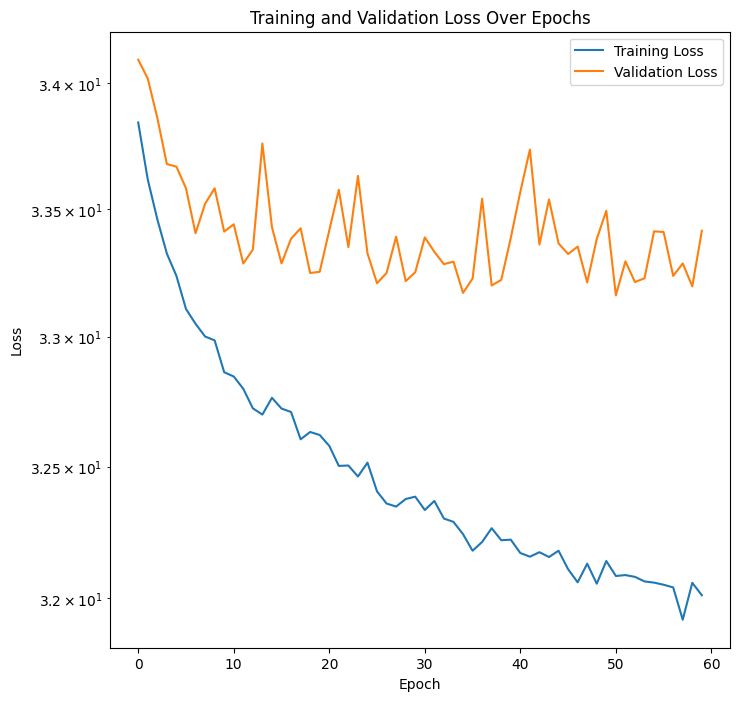

In [40]:
epochs_range = range(epochs)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
#plt.xlim([1,epochs])
#plt.ylim([0,2])
plt.semilogy()
plt.show()

In [41]:
import numpy as np
import estimator
import pandas as pd

# Load the new data
new_data = pd.read_csv("C:/Projects/Crosstalk/Machine_Learning/Data/2024-08-28_14-31/test.csv")
first_line = new_data.iloc[0]

# Extract the correct output for comparison
correct_output = first_line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].to_numpy()

# Prepare the input data (only the features, not the output columns)
input_features = first_line[keys].to_numpy().reshape(1, -1)  # Convert to 2D array

# Apply the same standardization and PCA transformation
scaled_input_features = scaler.transform(input_features)  # Standardize
pca_input_features = pca.transform(scaled_input_features)  # Apply PCA

# Make predictions using the model
predictions = model.predict(pca_input_features)

# Output the results
print("Predicted values: ", predictions[0])
print("Correct values: ", correct_output)
print("The mean squared error is: ", 0.3 * np.linalg.norm(predictions[0] - correct_output) ** 2)

# Calculate and print the percent error
error = estimator.percent_error(predictions[0], correct_output)
print("The percent error is: ", error * 100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted values:  [1.754499   0.5134845  0.30025268 0.15518996 0.25615755]
Correct values:  [1.66648545 0.35653262 0.53119262 0.26174146 0.9067299 ]
The mean squared error is:  0.15609333601169176
The percent error is:  54.13285845579402


In [42]:
errors = []
for i in range(len(new_data)):
    line = new_data.iloc[i]

    # Extract the correct output for comparison
    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].to_numpy()

    # Prepare the input data (only the features, not the output columns)
    input_features = line[keys].to_numpy().reshape(1, -1)  # Convert to 2D array

    # Apply the same standardization and PCA transformation
    scaled_input_features = scaler.transform(input_features)  # Standardize
    pca_input_features = pca.transform(scaled_input_features)  # Apply PCA

    # Make predictions using the model
    predictions = model.predict(pca_input_features)

    # Calculate the percent error and append it to the list
    errors.append(estimator.percent_error(predictions[0], correct_output))

# Output the average error, or you can analyze the errors list as needed
average_error = np.mean(errors)
print("Average percent error: ", average_error * 100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [43]:
print("The mean percent error is: ", np.mean(errors) * 100)

The mean percent error is:  61.80530034616365


In [36]:
error_dict = {key: [] for key in ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]}

for i in range(len(new_data)):
    line = new_data.iloc[i]

    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)

    # Calculate the percent error for each output key and append it to the respective list
    for j, key in enumerate(error_dict.keys()):
        error_dict[key].append(estimator.percent_error(predictions[0][j], correct_output[j]))


ValueError: Missing data for input "input_layer_4". You passed a data dictionary with keys ['X_0_0', 'X_0_1', 'X_0_2', 'X_0_3', 'Y_0_0', 'Y_0_1', 'Y_0_2', 'Y_0_3']. Expected the following keys: ['input_layer_4']

In [25]:
import pandas as pd

# Convert the error dictionary to a DataFrame
error_df = pd.DataFrame(error_dict)

# Calculate the mean of each error
mean_errors = error_df.mean()

# Display the results
for key, value in mean_errors.items():
    print(f"The mean error for {key} is: {value * 100} precent")

print("total error is: ", mean_errors.mean() * 100)

The mean error for decay_0 is: 952.7393967563879 precent
The mean error for decay_1 is: 503.35118982148623 precent
The mean error for W_0 is: 376.59837525586977 precent
The mean error for W_1 is: 97.37070031913521 precent
The mean error for J_0 is: 2470.934078528135 precent
total error is:  880.1987481362028


In [26]:

print(custom_loss(predictions[0], correct_output))
a = custom_loss(predictions[0], correct_output)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul] name: 